In [ ]:
# 4. Compile model and display history
# 4. plot confusion matrix

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import ModelCheckpoint

IMG_SIZE = (128, 128) # The same as for BlazeFace
BATCH_SIZE = 4 
PATH_TO_DATASET = '../datasets/test_train'
NUM_CLASSES = 4


In [15]:
train_ds = image_dataset_from_directory(f"{PATH_TO_DATASET}/train", labels='inferred', batch_size=BATCH_SIZE, image_size=IMG_SIZE)
test_ds = image_dataset_from_directory(f"{PATH_TO_DATASET}/test", labels='inferred', batch_size=BATCH_SIZE, image_size=IMG_SIZE)
CLASSES = train_ds.class_names

print(f"Found classes: {train_ds.class_names}")

assert len(train_ds.class_names) == len(test_ds.class_names) == NUM_CLASSES, f"Train and Test classes should be equal to {NUM_CLASSES}"
assert train_ds.class_names == test_ds.class_names, "Train and Test classes should be the same"

!find ../datasets/test_train/ -maxdepth 2 -type d -exec \
  /bin/sh -c 'find {} -type f | \
    echo "$(echo {} | cut -d'/' -f4,5): $(wc -l)" ' \;

Found 10203 files belonging to 4 classes.
Found 2550 files belonging to 4 classes.
Found classes: ['hand', 'hand_low_qual', 'low_qual', 'normal']
: 12753
test: 2550
test/normal: 800
test/hand: 700
test/hand_low_qual: 350
test/low_qual: 700
train: 10203
train/normal: 3199
train/hand: 2800
train/hand_low_qual: 1404
train/low_qual: 2800


height: 128, width: 128, channels: 3


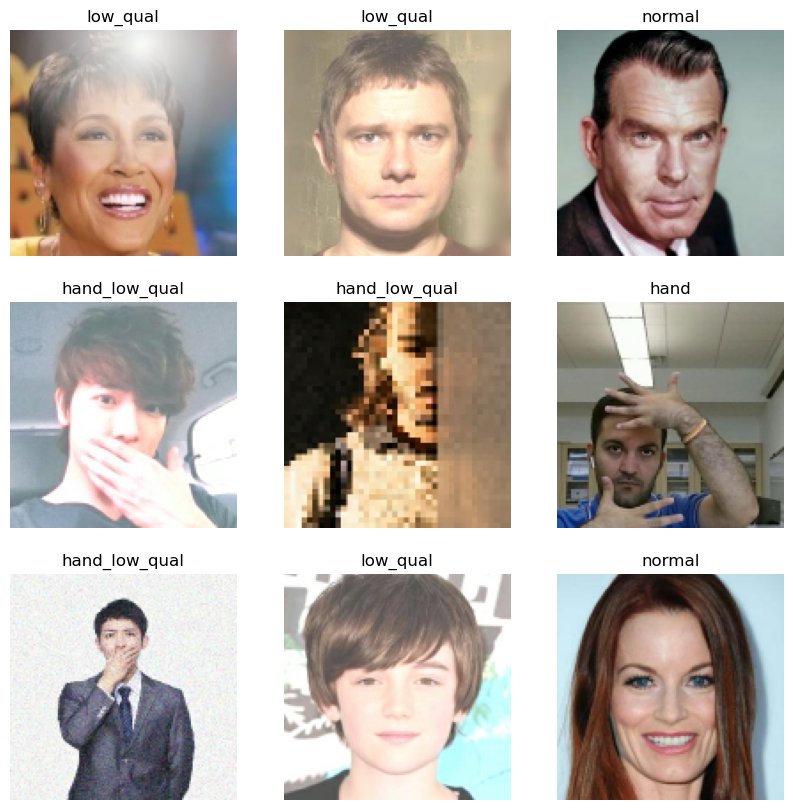

In [80]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")
print(f"height: {images.shape[1]}, width: {images.shape[2]}, channels: {images.shape[3]}")

In [5]:
AUTOTUNE = tf.data.AUTOTUNE # number of parallel calls is set dynamically based on available resources

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [6]:
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(NUM_CLASSES)
])

In [23]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint(
    filepath='../models/phase_2/phase_2_model.h5',  
    save_weights_only=False, 
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=2,
    callbacks=[checkpoint_callback] 
)

Epoch 1/2


2551/2551 [==============================] - ETA: 0s - loss: 0.1526 - accuracy: 0.9452
Epoch 1: val_loss improved from inf to 1.47221, saving model to ../models/phase_2/phase_2_model.h5
2551/2551 [==============================] - 120s 47ms/step - loss: 0.1526 - accuracy: 0.9452 - val_loss: 1.4722 - val_accuracy: 0.6992
Epoch 2/2
   1/2551 [..............................] - ETA: 2:27 - loss: 0.0058 - accuracy: 1.0000

/home/jakubner/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2551/2551 [==============================] - ETA: 0s - loss: 0.1158 - accuracy: 0.9603
Epoch 2: val_loss did not improve from 1.47221
2551/2551 [==============================] - 118s 46ms/step - loss: 0.1158 - accuracy: 0.9603 - val_loss: 2.6172 - val_accuracy: 0.5973


In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        9

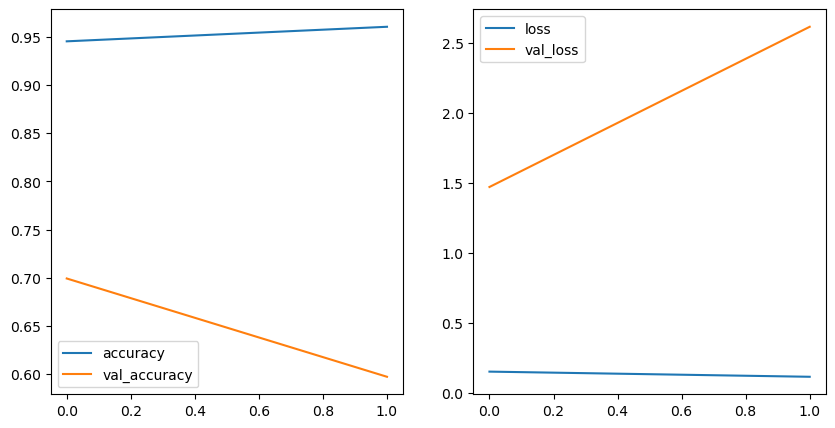

In [25]:
_, axs = plt.subplots(1, 2, figsize=(10, 5))  
axs[0].plot(history.history['accuracy'], label='accuracy')
axs[0].plot(history.history['val_accuracy'], label='val_accuracy')
axs[0].legend()

axs[1].plot(history.history['loss'], label='loss')
axs[1].plot(history.history['val_loss'], label='val_loss')
axs[1].legend()
plt.show()

638/638 [==============================] - 6s 9ms/step
Normalized confusion matrix
[[0.12142857 0.04       0.53571429 0.30285714]
 [0.10571429 0.03714286 0.55142857 0.30571429]
 [0.09714286 0.04142857 0.54428571 0.31714286]
 [0.09375    0.03625    0.57       0.3       ]]


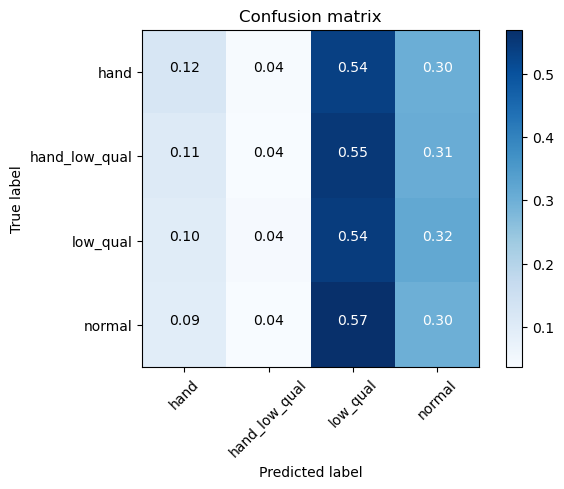

In [26]:
from sklearn.metrics import confusion_matrix
import sys

sys.path.append('./../')
from utils.phase_2 import plot_confusion_matrix

p_test = model.predict(test_ds).argmax(axis=1)
true_labels = np.concatenate([y.numpy() for x, y in test_ds], axis=0)
cm = confusion_matrix(true_labels, p_test)
plot_confusion_matrix(cm, CLASSES, normalize=True)